# Import library

In [3]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Import data

In [4]:
spark = SparkSession.builder.appName("Ecommerce").getOrCreate()

In [5]:
#import data
df = spark.read.csv('Online Retail.csv', header=True)

# Check data

In [6]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)



In [7]:
df.show(5)

+---------+---------+--------------------+--------+---------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|    InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+---------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|01/12/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|01/12/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|01/12/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|01/12/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|01/12/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+---------------+---------+----------+--------------+
only showing top 5 rows



In [8]:
print(f'nr of rows:{df.count()} \nnr of cols: {len(df.columns)}')

nr of rows:541909 
nr of cols: 8


In [9]:
#count NULL
from pyspark.sql.functions import col, when, count
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|       1454|       0|          0|        0|    135080|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [10]:
#statistics summary
df.select('Quantity', 'UnitPrice').summary().show()

+-------+------------------+-----------------+
|summary|          Quantity|        UnitPrice|
+-------+------------------+-----------------+
|  count|            541909|           541909|
|   mean|  9.55224954743324|4.611113626088333|
| stddev|218.08115785023458|96.75985306118008|
|    min|                -1|        -11062.06|
|    25%|               1.0|             1.25|
|    50%|               3.0|             2.08|
|    75%|              10.0|             4.13|
|    max|               992|            99.96|
+-------+------------------+-----------------+



In [11]:
#Number of customers, orders
df.select([countDistinct(c).alias(c) for c in ['InvoiceNo', 'StockCode', 'CustomerID']]).show()

+---------+---------+----------+
|InvoiceNo|StockCode|CustomerID|
+---------+---------+----------+
|    25900|     4070|      4372|
+---------+---------+----------+



In [12]:
#orders by countries
df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy(desc('country_count')).show()

+---------------+-------------+
|        Country|country_count|
+---------------+-------------+
| United Kingdom|         3950|
|        Germany|           95|
|         France|           87|
|          Spain|           31|
|        Belgium|           25|
|    Switzerland|           21|
|       Portugal|           19|
|          Italy|           15|
|        Finland|           12|
|        Austria|           11|
|         Norway|           10|
|        Denmark|            9|
|Channel Islands|            9|
|      Australia|            9|
|    Netherlands|            9|
|         Sweden|            8|
|         Cyprus|            8|
|          Japan|            8|
|         Poland|            6|
|         Greece|            4|
+---------------+-------------+
only showing top 20 rows



In [13]:
#cancelling order
cancel=df.withColumn('order_canceled', F.when(F.col('InvoiceNo').contains('C'), F.lit(1)).otherwise(F.lit(0)))
cancel.select(sum(cancel.order_canceled).alias('nr of cancel orders')).show()
cancel.filter(cancel.order_canceled == 1).show()

+-------------------+
|nr of cancel orders|
+-------------------+
|               9288|
+-------------------+

+---------+---------+--------------------+--------+----------------+---------+----------+--------------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|     InvoiceDate|UnitPrice|CustomerID|       Country|order_canceled|
+---------+---------+--------------------+--------+----------------+---------+----------+--------------+--------------+
|  C536379|        D|            Discount|      -1| 01/12/2010 9:41|     27.5|     14527|United Kingdom|             1|
|  C536383|   35004C|SET OF 3 COLOURED...|      -1| 01/12/2010 9:49|     4.65|     15311|United Kingdom|             1|
|  C536391|    22556|PLASTERS IN TIN C...|     -12|01/12/2010 10:24|     1.65|     17548|United Kingdom|             1|
|  C536391|    21984|PACK OF 12 PINK P...|     -24|01/12/2010 10:24|     0.29|     17548|United Kingdom|             1|
|  C536391|    21983|PACK OF 12 BLUE P...|     -2

# Data processing

In [14]:
# data type
df = df.withColumn("Quantity", col("Quantity").cast("integer"))
df = df.withColumn("UnitPrice", col("UnitPrice").cast("double"))
df=df.withColumn("InvoiceDate", to_timestamp(col("InvoiceDate"), "dd/MM/yyyy H:mm"))

#drop nan
df=df.na.drop("any")
    
df.dtypes

[('InvoiceNo', 'string'),
 ('StockCode', 'string'),
 ('Description', 'string'),
 ('Quantity', 'int'),
 ('InvoiceDate', 'timestamp'),
 ('UnitPrice', 'double'),
 ('CustomerID', 'string'),
 ('Country', 'string')]

# Feature engineering

In [15]:
#Recency
df.select(min("InvoiceDate")).show()
df = df.withColumn("from_date", lit("10/12/01 08:26"))
df = df.withColumn('from_date',to_timestamp("from_date", 'yy/MM/dd H:mm'))
df=df.withColumn('recency',col("InvoiceDate").cast("long") - col('from_date').cast("long"))

df_rec=df.groupBy('CustomerID').agg(max('recency').alias('recency'))
df_rec.printSchema()

+-------------------+
|   min(InvoiceDate)|
+-------------------+
|2010-12-01 08:26:00|
+-------------------+

root
 |-- CustomerID: string (nullable = true)
 |-- recency: long (nullable = true)



In [16]:
#Frequency
df_freq = df.groupBy('CustomerID').agg(count('InvoiceDate').alias('frequency'))
df_freq=df_freq.na.drop("any")
df_freq.printSchema()
df_freq.filter(col("CustomerID").isNull()).show()

root
 |-- CustomerID: string (nullable = true)
 |-- frequency: long (nullable = false)

+----------+---------+
|CustomerID|frequency|
+----------+---------+
+----------+---------+



In [17]:
#Monetary Value
df_m = df.withColumn('TotalAmount',col("Quantity") * col("UnitPrice"))
df_m  = df_m.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))
df_m.filter(col("CustomerID").isNull()).show()
df_m.printSchema()

+----------+--------------+
|CustomerID|monetary_value|
+----------+--------------+
+----------+--------------+

root
 |-- CustomerID: string (nullable = true)
 |-- monetary_value: double (nullable = true)



In [18]:
#Join 3 table
df_final=df_rec.join(df_freq,on='CustomerID',how='inner').join(df_m,on='CustomerID',how='inner' )
df_final.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- recency: long (nullable = true)
 |-- frequency: long (nullable = false)
 |-- monetary_value: double (nullable = true)



In [19]:
df_final=df_final.where(df_final.monetary_value>=0)

# Standardization

In [20]:
#Standardization
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assemble=VectorAssembler(inputCols=['recency','frequency','monetary_value'], outputCol='features', handleInvalid="skip")
assembled_data=assemble.transform(df_final)
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

In [21]:
data_scale_output.summary().show()

+-------+------------------+--------------------+------------------+------------------+
|summary|        CustomerID|             recency|         frequency|    monetary_value|
+-------+------------------+--------------------+------------------+------------------+
|  count|              4329|                4329|              4329|              4329|
|   mean|15298.686763686763|2.4476210214830216E7| 93.91707091707092|1920.3730547470518|
| stddev| 1721.668045765092|   8565965.975570478|233.45949691089473| 8256.804337753178|
|    min|             12346|                5220|                 1|               0.0|
|    25%|           13812.0|            20321160|                18|            301.03|
|    50%|           15297.0|            28005840|                42| 656.6800000000001|
|    75%|           16778.0|            30856440|               102|1624.2099999999996|
|    max|             18287|            32243040|              7983| 279489.0199999998|
+-------+------------------+----

# Clustering

In [22]:
# find k
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

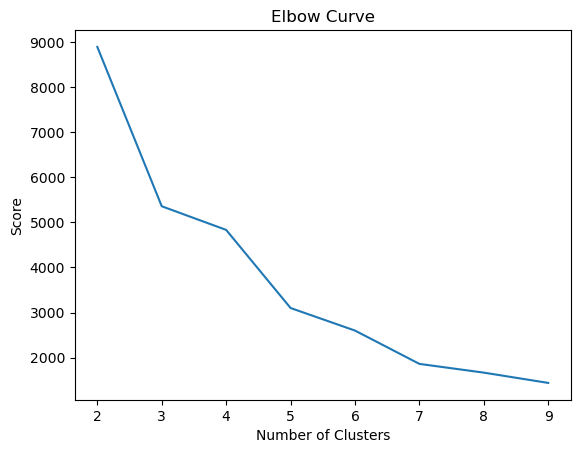

In [23]:
import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [24]:
#train model with k=5
KMeans_algo=KMeans(featuresCol='standardized', k=5)
KMeans_fit=KMeans_algo.fit(data_scale_output)

In [25]:
preds=KMeans_fit.transform(data_scale_output)

preds.show(5)

+----------+--------+---------+------------------+--------------------+--------------------+----------+
|CustomerID| recency|frequency|    monetary_value|            features|        standardized|prediction|
+----------+--------+---------+------------------+--------------------+--------------------+----------+
|     16250| 9700860|       24|389.44000000000005|[9700860.0,24.0,3...|[1.13248873830063...|         2|
|     15574|16943700|      168| 702.2500000000002|[1.69437E7,168.0,...|[1.97802560135333...|         2|
|     15555|31218780|      925|4758.2000000000035|[3.121878E7,925.0...|[3.64451365894211...|         0|
|     15271|31643100|      275|           2485.82|[3.16431E7,275.0,...|[3.69404922810152...|         0|
|     17714| 4586760|       10|             153.0|[4586760.0,10.0,1...|[0.53546325225679...|         2|
+----------+--------+---------+------------------+--------------------+--------------------+----------+
only showing top 5 rows



# Cluster analysis

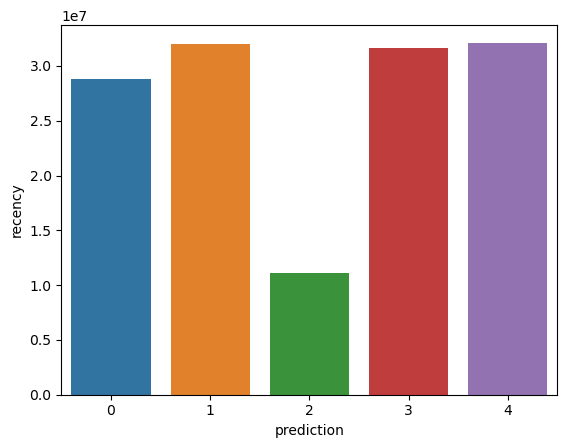

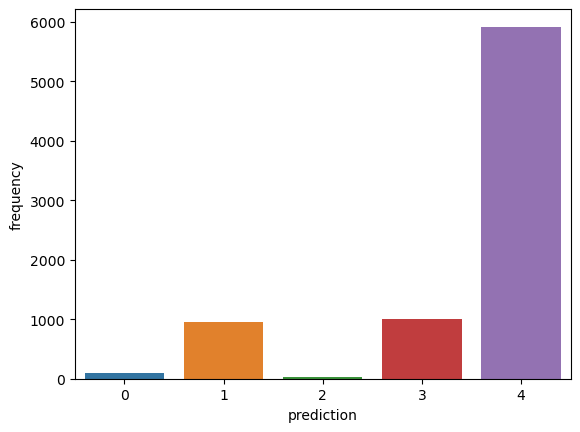

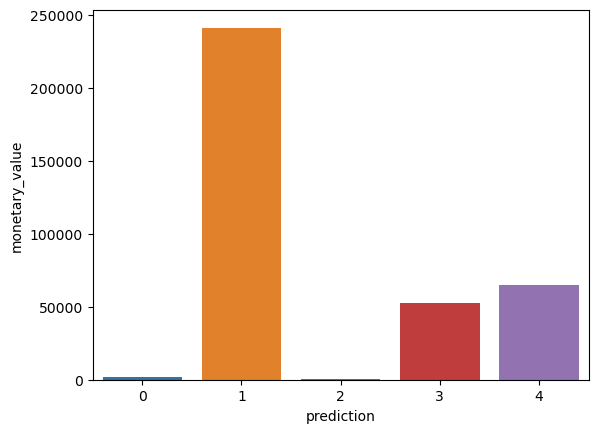

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()